In [ ]:
# Authors: Jessica Su, Wanzi Zhou, Pratyaksh Sharma, Dylan Liu, Ansh Shukla

import numpy as np
import random
import time
import pdb, os
import unittest
from PIL import Image
import matplotlib.pyplot as pl
pl.close('all')

# Finds the L1 distance between two vectors
# u and v are 1-dimensional np.array objects
def l1(u, v):
    return np.linalg.norm(u - v, ord=1)

# Loads the data into a np array, where each row corresponds to
# an image patch -- this step is sort of slow.
# Each row in the data is an image, and there are 400 columns.
def load_data(filename):
    return np.genfromtxt(filename, delimiter=',')

# Creates a hash function from a list of dimensions and thresholds.
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

In [ ]:
# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0,
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold,
                                   high = max_threshold + 1,
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

In [ ]:
# Hashes an individual vector (i.e. image).  This produces an array with L
# entries, where each entry is a string of k bits.
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

In [ ]:
# Hashes the data in A, where each row is a datapoint, using the L
# functions in "functions."
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

In [ ]:
# Retrieve all of the points that hash to one of the same buckets
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

In [ ]:
# Sets up the LSH.  You should try to call this function as few times as
# possible, since it is expensive.
# A: The dataset.
# Return the LSH functions and hashed data structure.
def lsh_setup(A, k = 24, L = 10):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)

In [ ]:
# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)

    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]
    return list(zip(*best_neighbors))
#    return [t[0] for t in best_neighbors]

In [ ]:
# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for i, row_num in enumerate(row_nums):
        patch = np.reshape(A[row_num, :], [20, 20]).T
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
#        im.save(base_filename + "-" + str(row_num) + ".png")
        im.save('%s_%d_%05d.png' % (base_filename, i, row_num))

In [ ]:
# Finds the nearest neighbors to a given vector, using linear search.
def linear_search(A, query_indices, num_neighbors):
    t0 = time.time()
    errors = np.ones((len(query_indices), num_neighbors)) * np.inf
    indices = np.zeros((len(query_indices), num_neighbors), dtype=np.int)
    for icand in range(A.shape[0]):
        candImg = A[icand]
        for iquery in range(len(query_indices)):
            queryIdx = query_indices[iquery]
            if queryIdx == icand:
                continue

            queryImg = A[queryIdx]
            dist = l1(queryImg, candImg)
            for ineig in range(num_neighbors):
                if dist < errors[iquery, ineig]:
                    break
            else:
                continue
            errors[iquery, ineig] = dist
            indices[iquery, ineig] = icand

    print('linear: avg time per query = %f' % ((time.time() - t0) / len(query_indices)))
    return indices, errors

In [ ]:
def error(lsh_err, lin_err):
    return np.mean(np.sum(lsh_err[:, :3], axis=1) / np.sum(lin_err[:, :3], axis=1))

def lsh_wrapper(A, k, L, query_indices, num_neighbors):
    np.random.seed(0)

    t0 = time.time()
    functions, hashed_A = lsh_setup(A, k, L)
    print('k %d L %d: hash time %f' % (k, L, time.time() - t0))

    t1 = time.time()
    lsh_idx = []
    lsh_err = []
    for queryIdx in query_indices:
        while True:
            idx, err = lsh_search(A, hashed_A, functions, queryIdx, num_neighbors)
            if len(err) == num_neighbors:
                break
            print('not enough neigs chosen')
        lsh_idx.append(idx)
        lsh_err.append(err)
    lsh_idx = np.array(lsh_idx)
    lsh_err = np.array(lsh_err)

    t2 = time.time()
    print('k %d L %d: avg time per query (no   initial hash) %f' % (k, L, (t2 - t1) / len(query_indices)))
    print('k %d L %d: avg time per query (plus initial hash) %f' % (k, L, (t2 - t0) / len(query_indices)))
    return lsh_idx, lsh_err

In [ ]:
def problem4_run(A, query_indices, num_neighbors, resultsDataPath):
    lin_idx, lin_err = linear_search(A, query_indices, num_neighbors)

    # changing L
    run1_k = [24] * 6
    run1_L = [20, 18, 16, 14, 12, 10]
    run1_i = []
    run1_e = []
    for k, L in zip(run1_k, run1_L):
        lsh_idx, lsh_err = lsh_wrapper(A, k, L, query_indices, num_neighbors)
        run1_i.append(lsh_idx)
        run1_e.append(lsh_err)

    # changing k
    run2_k = [16, 18, 20, 22]
    run2_L = [10] * 4
    run2_i = []
    run2_e = []
    for k, L in zip(run2_k, run2_L):
        lsh_idx, lsh_err = lsh_wrapper(A, k, L, query_indices, num_neighbors)
        run2_i.append(lsh_idx)
        run2_e.append(lsh_err)
    run2_k.append(run1_k[-1])
    run2_L.append(run1_L[-1])
    run2_i.append(run1_i[-1]) # ref is fine
    run2_e.append(run1_e[-1])

    np.savez(resultsDataPath,
             lin_idx=lin_idx, lin_err=lin_err,
             run1_k=run1_k, run1_L=run1_L, run1_i=run1_i, run1_e=run1_e,
             run2_k=run2_k, run2_L=run2_L, run2_i=run2_i, run2_e=run2_e)

In [ ]:
!pwd

/content


In [ ]:
my_path = '/content/drive/MyDrive/hw1/q4'

In [ ]:
def problem4():
    # data
    # npzDataPath = './data/patches_uint8.npz'
    npzDataPath = my_path + '/data/patches_uint8.npz'
    if not os.path.isfile(npzDataPath):
        t0 = time.time()
        A = np.genfromtxt(my_path + '/data/patches.csv', delimiter=',')
        np.savez(npzDataPath, A_uint8=np.uint8(A))
        print('loading matrix used %f seconds' % (time.time() - t0))

    print('npz matrix exists. loading..')
    f = np.load(npzDataPath)
    A = np.float64(f['A_uint8'])

    query_indices = [99, 199, 299, 399, 499, 599, 699, 799, 899, 999]
    num_neighbors = 10

    # run
    resultsDataPath = my_path + '/data/results.npz'
    if not os.path.isfile(resultsDataPath):
        problem4_run(A, query_indices, num_neighbors, resultsDataPath)

    print('saved results exist. loading..')
    f = np.load(resultsDataPath)

    # plot
    lin_idx = f['lin_idx']
    lin_err = f['lin_err']
    run1_k = f['run1_k']
    run1_L = f['run1_L']
    run1_i = f['run1_i']
    run1_e = f['run1_e']
    run2_k = f['run2_k']
    run2_L = f['run2_L']
#    run2_i = f['run2_i']
    run2_e = f['run2_e']

    run1_error = []
    run2_error = []
    for i in range(run1_L.shape[0]):
        run1_error.append(error(run1_e[i], lin_err))
    for i in range(run2_k.shape[0]):
        run2_error.append(error(run2_e[i], lin_err))

    fig, ax = pl.subplots(1, 2, sharey=True)
    ax[0].plot(run1_L, run1_error)
    ax[1].plot(run2_k, run2_error)
    ax[0].set_xlabel('L')
    ax[1].set_xlabel('k')
    ax[0].legend(['k = %d' % run1_k[0]])
    ax[1].legend(['L = %d' % run2_L[0]])

    iquery = 0
    plot(A, lin_idx[iquery]        , my_path + '/data/lin')
    plot(A, run1_i[-1][iquery]     , my_path + '/data/lsh')
    plot(A, [query_indices[iquery]], my_path + '/data/qry')

In [ ]:
#### TESTS #####

class TestLSH(unittest.TestCase):
    def test_l1(self):
        u = np.array([1, 2, 3, 4])
        v = np.array([2, 3, 2, 3])
        self.assertEqual(l1(u, v), 4)

    def test_hash_data(self):
        f1 = lambda v: sum(v)
        f2 = lambda v: sum([x * x for x in v])
        A = np.array([[1, 2, 3], [4, 5, 6]])
        self.assertEqual(f1(A[0,:]), 6)
        self.assertEqual(f2(A[0,:]), 14)

        functions = [f1, f2]
        self.assertTrue(np.array_equal(hash_vector(functions, A[0, :]), np.array([6, 14])))
        self.assertTrue(np.array_equal(hash_data(functions, A), np.array([[6, 14], [15, 77]])))

loading matrix used 38.926989 seconds
npz matrix exists. loading..
linear: avg time per query = 0.598007
k 24 L 20: hash time 30.089733
k 24 L 20: avg time per query (no   initial hash) 0.170660
k 24 L 20: avg time per query (plus initial hash) 3.179649
k 24 L 18: hash time 26.769182
k 24 L 18: avg time per query (no   initial hash) 0.159495
k 24 L 18: avg time per query (plus initial hash) 2.836427
k 24 L 16: hash time 24.331277
k 24 L 16: avg time per query (no   initial hash) 0.155877
k 24 L 16: avg time per query (plus initial hash) 2.589019
k 24 L 14: hash time 21.067004
k 24 L 14: avg time per query (no   initial hash) 0.148136
k 24 L 14: avg time per query (plus initial hash) 2.254852
k 24 L 12: hash time 17.986737
k 24 L 12: avg time per query (no   initial hash) 0.143049
k 24 L 12: avg time per query (plus initial hash) 1.941737
k 24 L 10: hash time 14.769792
k 24 L 10: avg time per query (no   initial hash) 0.135681
k 24 L 10: avg time per query (plus initial hash) 1.612674
k

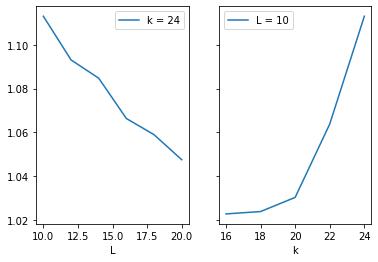

In [ ]:
if __name__ == '__main__':
#    unittest.main()
    problem4()